# Bayesian A/B Testing

In our hypothetical example, we will pretend we are a small team of statisticians at the Office of Inspector General (OIG), tasked with assessing fraud. We have two methods of auditing the financial practices of the Department of Veterans Affairs: on-site audits or desk audits.  

1. **Program A**: conduct on-site physical audits at the locations under investigation. Our recent past data shows that **9 out of 60 (15%)** audits resulted in fraud. This is the *observed frequency* of program A uncovering fraud. It's not necessarily the *true frequency* or the *true probability* that program A uncovers fraud since these data are a sample. The data do not consider the plausible alternative audits under program A that could have occurred but did not. In other words, there is uncertainty in our data. 

2. **Program B**: conduct desk audits, where all work is conducted from the home office with no physical presence at the location under investigation. Our recent past data shows that **4 out of 35 (13%)** audits resulted in fraud.

**Our Goal**: We want to express the uncertainty of our beliefs using easy to understand probability statements regarding the differences in fraud detection rates between program A and program B.

While we can clearly see some differences in the observed data upon first glance, the data available to us are highly uncertain quantities. We want to model this uncertainty to infer the most likely true probabilities of fraud under programs A and B, in order to be able to make intuitive statements such as:

"*There's an X% probability that program A is more effective than program B due to its higher fraud rate.*" 

or 

"*We are 95% confident that program A's fraud detection rate could be anywhere from Y% to Z% better than program B's.*"

We can make these types of statements under the Bayesian inference approach to statistics, which generates probability distributions as outputs as opposed to single point estimates. All we need is a distribution for realistic/representative prior beliefs about program A and B, our data for program A and B (to model a generative likelihood function), and combine these to arrive at posterior beliefs (updating original beliefs after observing data) about their respective fraud rates.

## Uniform Prior Beliefs

Under these assumptions, we'll assume that all probabilities are equally likely for program A's and program B's fraud rates. That means that before seeing the data, a 0% fraud rate was just as plausible as 50% and 100% for either program A or B. Probably unrealistic.    

In [68]:
# https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline/43028034
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def binomial_grid_approx(successes, n_trials, grid_length=100):
    """Estimate the posterior distribution of set of 
    observations that can be modeled as a binomial distribution 
    Use grid approximation. Assume a uniform prior."""
    
    # define grid of possible values of p
    p_grid = np.linspace(0, 1, grid_length)
    # define a uniform prior
    prior = np.ones(grid_length)/grid_length
    # calculate the prob mass function, given different values of p. 
    likelihood = stats.binom.pmf(successes, n_trials, p_grid) 
    # estimate the posterior distribution: P(data | p_grid) * P(p_grid)
    unnormalized_posterior = likelihood * prior # vectorized math

    posterior = unnormalized_posterior / unnormalized_posterior.sum()
    
    return p_grid, posterior

Now run the function over the 2 observed datasets to return posterior probability distributions for program A and program B's fraud rates. 

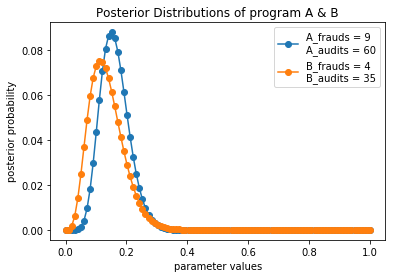

In [96]:
# observed data
A_fraud, A_audits = 9, 60
B_fraud, B_audits = 4, 35

p_grid, posterior_A = binomial_grid_approx(A_fraud, A_audits, 100)
p_grid, posterior_B = binomial_grid_approx(B_fraud, B_audits, 100)


plt.plot(p_grid, posterior_A, 'o-', label='A_frauds = {}\nA_audits = {}'.format(A_fraud, A_audits))
plt.plot(p_grid, posterior_B, 'o-', label='B_frauds = {}\nB_audits = {}'.format(B_fraud, B_audits))
plt.title('Posterior Distributions of program A & B')
plt.ylabel('posterior probability')
plt.xlabel('parameter values')
plt.legend(loc=0)
plt.show()

The above grid approximation approach produces posterior probability distributions of our **2 parameters of interest**:

* program A's true fraud rate
* program B's true fraud rate 

In order to compare these posterior probability distributions to each other, we need to simulate samples from each of them, then count and compare their frequencies over different intervals (*a practical way to calculate integrals*. See Statistical Rethinking Ch.2) in order to answer specific probability questions about the data!

Imagine we draw 1,000 samples from each of program A's posterior distribution. We can think of each sample being drawn from a bucket that's filled with **parameter values** that exist proportionally to program A's posterior distribution graphed above. For instance, ~9% of the samples will have a sample value of ~16%, the mode of program A's posterior distribution. **The key takeaway is that if we sample a large enough number of times from the posterior, the sample parameter values will appear proportionally to the posterior distribution.** All remaining data analysis then simply becomes a matter of tallying frequencies to arrive at probabilistic inferences.

In [126]:
np.random.seed(123)
post_samples_A = np.random.choice(p_grid, size=10000, replace=True, p=posterior_A)
post_samples_B = np.random.choice(p_grid, size=10000, replace=True, p=posterior_B)
post_samples_diff = post_samples_A - post_samples_B

Having generated posterior samples of the true fraud rate for program's A and B, we can now answer some of our questions.

*"What's the probability that program A is more effective than program B at catching fraud?"*

In [127]:
prob = round(100 * np.mean(post_samples_A > post_samples_B))
print('There is only a {}% probability that program A has a higher fraud rate than program B'.format(prob))

There is only a 63.0% probability that program A has a higher fraud rate than program B


"What is the most likely range of how program A's fraud rate differs from program B's fraud rate? Can we quantify this at 95% confidence?" 

In [150]:
(np.percentile(post_samples_diff, 2.5), np.percentile(post_samples_diff, 97.5))

(-0.12121212121212123, 0.1616161616161616)